# 3DAlternate - MLflow

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Load Data

In [2]:
from recognizer.utils.constants import ROOT_DIR, TARGET_TO_ENCODING
from recognizer.utils.utils import get_metadata_from_filename

DATASET_DIR_POSTA = ROOT_DIR / "data" / "all-20percent"

In [3]:
import os

import pandas as pd

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR_POSTA):

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR_POSTA / file).resolve()))


metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata["target_encoding"] = metadata["target"].map(TARGET_TO_ENCODING)

metadata.head()

,target,subject,repetition,file,target_encoding
0,001,001,001,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
1,001,001,002,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
2,001,001,003,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
3,001,001,004,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
4,001,001,005,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0


### Train/Test split

In [4]:
import numpy as np

size = 1
replace = False
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

testing_set = metadata.groupby(["target", "subject"], as_index=False).apply(fn)

testing_set.index = testing_set.index.droplevel(0)

training_set = metadata.loc[~metadata.index.isin(testing_set.index), :]

### Pre-processing functions

In [5]:
def transform(x):
    """Permutes the element to match the format expected by PyTorch: (C<channels>, T<frames>, H<height>, W<width>)"""
    # Transpose video from (T<frames>, H<height>, W<width>, C<channels>) to (C<channels>, T<frames>, H<height>, W<width>)
    return x.permute(3, 0, 1, 2).float()


### Parameters

In [39]:
BATCH_SIZE = 24
NUM_CLASSES = 64
NUM_FRAMES = 16
EPOCHS = 50
LR = 0.001

In [40]:
from recognizer.dataset import SampledVideoDataset

training_dataset = SampledVideoDataset(
    video_filenames=training_set["file"].values,
    labels=training_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

testing_dataset = SampledVideoDataset(
    video_filenames=testing_set["file"].values,
    labels=testing_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

print(f"Training/testing set: ({len(training_dataset)}, {len(testing_dataset)})")

Training/testing set: (2560, 640)


In [41]:
testing_set.groupby("target_encoding").count()

,target,subject,repetition,file
target_encoding,,,,
0,10,10,10,10
1,10,10,10,10
2,10,10,10,10
3,10,10,10,10
4,10,10,10,10
...,...,...,...,...
59,10,10,10,10
60,10,10,10,10
61,10,10,10,10


In [42]:
UNIQUE_CLASSES = metadata.target_encoding.unique()

### Data Loaders

In [43]:
import torch 
from torch import nn

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle = True)

test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [44]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device

'cuda'

### Model

In [45]:
from recognizer.models.alternate_3d import Alt3DCNN_v2

model = Alt3DCNN_v2(
    num_classes=NUM_CLASSES,
    num_frames=NUM_FRAMES,
    batch_size=BATCH_SIZE,
    input_shape=(24, 3, 16, 216, 384)
)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

loss_function = nn.CrossEntropyLoss()

In [75]:
from torchsummary import summary

summary(model, (3, 16, 216, 384), batch_size=24)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [24, 4, 16, 216, 384]           1,504
              ReLU-2      [24, 4, 16, 216, 384]               0
         MaxPool3d-3       [24, 4, 9, 109, 193]               0
       BatchNorm3d-4       [24, 4, 9, 109, 193]               8
            Conv3d-5       [24, 8, 9, 109, 193]             872
              ReLU-6       [24, 8, 9, 109, 193]               0
         MaxPool3d-7         [24, 8, 9, 55, 97]               0
       BatchNorm3d-8         [24, 8, 9, 55, 97]              16
            Conv3d-9        [24, 12, 9, 55, 97]           2,604
             ReLU-10        [24, 12, 9, 55, 97]               0
        MaxPool3d-11        [24, 12, 9, 28, 49]               0
      BatchNorm3d-12        [24, 12, 9, 28, 49]              24
           Linear-13                  [24, 100]      14,817,700
             ReLU-14                  [

In [47]:
dummy_input = torch.randn(24, 3, 16, 216, 384).cuda()

output = model(dummy_input)

print("Output shape:", output.shape)  # Should be [24, 64]

Output shape: torch.Size([24, 64])


In [48]:
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params: {p}")

Params: 14829392


In [49]:
for n, p in model.named_parameters():
    print(f"Param: {n} | Shape: {p.shape}")

Param: conv_layer_1.0.weight | Shape: torch.Size([4, 3, 5, 5, 5])
Param: conv_layer_1.0.bias | Shape: torch.Size([4])
Param: conv_layer_1.3.weight | Shape: torch.Size([4])
Param: conv_layer_1.3.bias | Shape: torch.Size([4])
Param: conv_layer_2.0.weight | Shape: torch.Size([8, 4, 3, 3, 3])
Param: conv_layer_2.0.bias | Shape: torch.Size([8])
Param: conv_layer_2.3.weight | Shape: torch.Size([8])
Param: conv_layer_2.3.bias | Shape: torch.Size([8])
Param: conv_layer_3.0.weight | Shape: torch.Size([12, 8, 3, 3, 3])
Param: conv_layer_3.0.bias | Shape: torch.Size([12])
Param: conv_layer_3.3.weight | Shape: torch.Size([12])
Param: conv_layer_3.3.bias | Shape: torch.Size([12])
Param: fc_layer.0.weight | Shape: torch.Size([100, 148176])
Param: fc_layer.0.bias | Shape: torch.Size([100])
Param: fc_layer.2.weight | Shape: torch.Size([100])
Param: fc_layer.2.bias | Shape: torch.Size([100])
Param: fc_layer.4.weight | Shape: torch.Size([64, 100])
Param: fc_layer.4.bias | Shape: torch.Size([64])


## Set Up Experiment in MLflow

In [50]:
import mlflow
import os

from mlflow.entities import Experiment
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_SERVER_URI = "http://localhost:5001"

os.environ["AWS_ACCESS_KEY_ID"] = "miniouser"
os.environ["AWS_SECRET_ACCESS_KEY"] = "miniopass"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000/"

mlflow.set_tracking_uri(MLFLOW_TRACKING_SERVER_URI)
mlflow_client = MlflowClient(MLFLOW_TRACKING_SERVER_URI)

In [ ]:
EXPERIMENT_NAME = "3D Alternate 01"

experiment: Experiment = mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

In [52]:
RUN_NAME = "Execution 10"

run = None

matching_runs = mlflow_client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName = '{RUN_NAME}'"
)

if len(matching_runs) > 0:
    raise Exception("Pisando run existente!!!!!")

run = mlflow_client.create_run(experiment_id=experiment.experiment_id)

mlflow_client.set_tag(run_id=run.info.run_id, key="mlflow.runName", value=RUN_NAME)

print(f"Run '{RUN_NAME}' creado con ID '{run.info.run_id}'")

Run 'Execution 10' creado con ID '642d531a2c494c3493bc192f46a68c0a'


### Log Params

In [53]:
mlflow_client.log_param(run_id=run.info.run_id, key="BATCH_SIZE", value=BATCH_SIZE)
mlflow_client.log_param(run_id=run.info.run_id, key="NUM_CLASSES", value=NUM_CLASSES)
mlflow_client.log_param(run_id=run.info.run_id, key="EPOCHS", value=EPOCHS)
mlflow_client.log_param(run_id=run.info.run_id, key="NUM_FRAMES", value=NUM_FRAMES)
mlflow_client.log_param(run_id=run.info.run_id, key="LR", value=LR)

print("Params successfully logged")

Params successfully logged


In [54]:
mlflow_client.log_text(run_id=run.info.run_id, text=str(testing_set.index.values), artifact_file="testing set index.txt")

## Training

In [55]:
import subprocess

CMD = '''
on run argv
  display notification (item 2 of argv) with title (item 1 of argv) sound name "Glass"
end run
'''

def notify(title, text):
    subprocess.call(['osascript', '-e', CMD, title, text])

In [56]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

cm = None

metrics = {
    "training_loss": [],
    "testing_loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [57]:
print(
f"""
Beginning model training with parameters:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
"""
)

best_loss = np.inf
patience = 3
delta = 0.01
epochs_without_improvement = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} - Training phase")

    model.train()

    running_training_loss = 0.0

    for _, data in enumerate(train_loader):

        batch, labels = data[0].to(device), data[1].to(device)

        logits = model(batch)

        loss = loss_function(logits, labels)

        running_training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_training_loss = running_training_loss / len(train_loader)
    metrics["training_loss"].append(round(average_training_loss, 2))

    print(f"    - AVG Training Loss: {average_training_loss:.2f}")

    # Evaluation
    print(f"Epoch {epoch + 1} - Evaluation phase")

    model.eval()

    all_preds = []
    all_targets = []

    running_testing_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            logits = model(inputs)

            _, preds = torch.max(logits, 1)

            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())

            loss = loss_function(logits, labels)
            running_testing_loss += loss.item()

    average_testing_loss = running_testing_loss / len(test_loader)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    assert len(all_preds) == len(all_targets) == 640
    assert len(np.unique(all_targets)) == NUM_CLASSES

    unique_preds = set(all_preds.numpy())
    missing_classes = set(UNIQUE_CLASSES) - unique_preds

    if missing_classes:
        print(f"    The following classes ({len(missing_classes)}) were not predicted: {missing_classes}")

    metrics["testing_loss"].append(round(average_testing_loss, 2))
    metrics["accuracy"].append(accuracy_score(all_targets, all_preds))
    metrics["precision"].append(precision_score(all_targets, all_preds, average="macro", zero_division=0, labels=UNIQUE_CLASSES))
    metrics["recall"].append(recall_score(all_targets, all_preds, average="macro", zero_division=0, labels=UNIQUE_CLASSES))
    metrics["f1"].append(f1_score(all_targets, all_preds, average="macro", zero_division=0, labels=UNIQUE_CLASSES))

    for metric in metrics.keys():
        mlflow_client.log_metric(
            run_id=run.info.run_id,
            key=metric,
            value=metrics[metric][epoch],
            step=epoch,
        )
    
    print(f"""
    - Testing Loss: {metrics['testing_loss'][-1]}
    - Accuracy  : {metrics['accuracy'][-1]}
    - Precision : {metrics['precision'][-1]}
    - Recall    : {metrics['recall'][-1]}
    - F1        : {metrics['f1'][-1]}
    """)

    if average_testing_loss < best_loss - delta:
        best_loss = average_testing_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. Testing loss is not improving!")
        break

    if epoch == EPOCHS - 1:
        cm = confusion_matrix(all_targets, all_preds)



Beginning model training with parameters:
- Epochs: 50
- Batch Size: 24

Epoch 1 - Training phase
    - AVG Training Loss: 3.14
Epoch 1 - Evaluation phase
    The following classes (13) were not predicted: {2, 38, 39, 40, 9, 42, 11, 43, 45, 55, 25, 58, 61}

    - Testing Loss: 10.87
    - Accuracy  : 0.3078125
    - Precision : 0.4763296520684428
    - Recall    : 0.30781250000000004
    - F1        : 0.2961243305777133
    
Epoch 2 - Training phase
    - AVG Training Loss: 1.54
Epoch 2 - Evaluation phase

    - Testing Loss: 0.96
    - Accuracy  : 0.9296875
    - Precision : 0.9447405025530026
    - Recall    : 0.9296875
    - F1        : 0.9257137507376225
    
Epoch 3 - Training phase
    - AVG Training Loss: 0.63
Epoch 3 - Evaluation phase

    - Testing Loss: 0.42
    - Accuracy  : 0.96875
    - Precision : 0.971780303030303
    - Recall    : 0.96875
    - F1        : 0.9683417964474468
    
Epoch 4 - Training phase
    - AVG Training Loss: 0.24
Epoch 4 - Evaluation phase

    - 

## Evaluation

### Confusion Matrix

In [58]:
cm = confusion_matrix(all_targets, all_preds)

<AxesSubplot: >

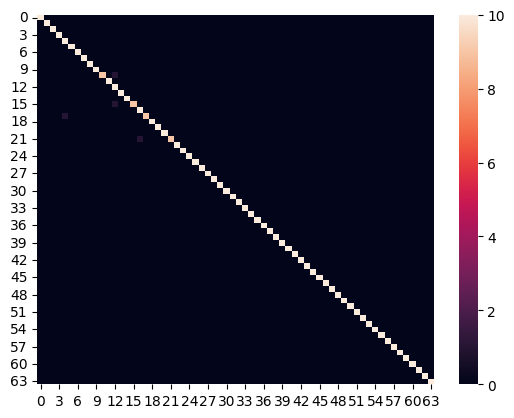

In [76]:
import seaborn as sns

sns.heatmap(data=cm)

### Accuracy/Recall/Precision

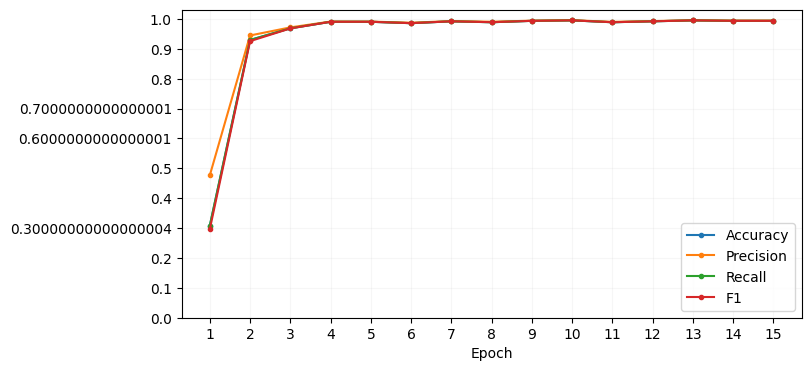

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(metrics["accuracy"], label="Accuracy", marker=".")
ax.plot(metrics["precision"], label="Precision", marker=".")
ax.plot(metrics["recall"], label="Recall", marker=".")
ax.plot(metrics["f1"], label="F1", marker=".")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

### Loss

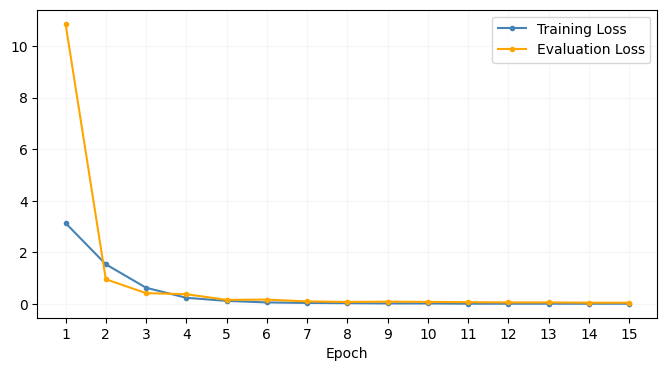

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(metrics["training_loss"], label="Training Loss", marker=".", color="steelblue")
ax.plot(metrics["testing_loss"], label="Evaluation Loss", marker=".", color="orange")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

## Save model

In [62]:
import copy
from recognizer.utils.constants import ROOT_DIR

MODELS_DIR = ROOT_DIR / "models"

MODEL_PATH = MODELS_DIR / f"{EXPERIMENT_NAME}_{RUN_NAME}.pth"

if MODEL_PATH.exists():
        raise Exception("El modelo ya existe!!!!")

with open(MODEL_PATH, "w") as f:
        f.write("")

torch.save(copy.deepcopy(model.state_dict()), f=MODEL_PATH)

In [63]:
mlflow_client.log_artifact(
    run_id=run.info.run_id,
    local_path=str(MODEL_PATH),
    artifact_path="",
)

In [64]:
import tempfile
import os

# Save the arrays to temporary npy files
with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as f:
    np.save(f, all_targets)
    ground_truth_path = f.name

    f.close()

    # Log the files to MLflow
    mlflow_client.log_artifact(
        run_id=run.info.run_id,
        local_path=ground_truth_path, 
        artifact_path="ground_truth"
    )


with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as f:
    np.save(f, all_preds)
    predictions_path = f.name

    f.close()

    mlflow_client.log_artifact(
        run_id=run.info.run_id,
        local_path=predictions_path, 
        artifact_path="predictions"
    )


In [65]:
mlflow.end_run()

## Clasificación manual

In [66]:
import random

idx = random.randint(0, BATCH_SIZE-1)

batch, klasses = next(iter(test_loader))

sign_video = batch[idx]

klass = klasses[idx]

In [67]:
sign_video = sign_video.unsqueeze(0)
sign_video.shape

torch.Size([1, 3, 16, 216, 384])

In [68]:
model.eval()

logits = model(sign_video.to(device))

In [69]:
logits

tensor([[ 0.8604, 10.4288,  3.8010, -0.3207,  1.0296,  0.0648, -1.9901,  0.6657,
         -0.5896,  0.5903, -0.2110,  0.9692, -1.5475,  0.1111,  1.3680, -0.3683,
          1.4054,  0.2652,  1.5442,  0.5981, -0.5871, -2.7517, -0.2596, -1.8352,
         -1.9866, -1.5107, -1.8530,  0.5043,  1.0216,  0.1720, -0.0857, -2.6612,
         -2.5683, -0.0840, -0.9784, -3.7898,  0.8234, -1.8161, -0.8190, -1.2320,
         -0.1065, -0.4224, -0.2630,  1.5274, -0.5219,  0.2140, -0.7933, -1.5992,
          0.1395, -1.4417,  0.9000, -1.7291, -0.4774, -1.4157, -1.3129,  1.4755,
          1.4551,  0.1505, -2.3362, -0.0158,  0.0322,  0.5129,  0.2499,  0.6764]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [70]:
from torch import nn

pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Ground Truth: {klass}. Predicted class: {y_pred}")

Ground Truth: 1. Predicted class: tensor([1], device='cuda:0')


In [71]:
raise Exception("No pasar de acá")

Exception: No pasar de acá

## Loading the model

In [ ]:
def load_state_dict(run_id: str, model_path: str):
    return mlflow_client.download_artifacts(
        run_id=run_id,
        path=model_path,
    )

In [ ]:
state_dict_path = load_state_dict(run_id=run.info.run_id, model_path=f"{EXPERIMENT_NAME}_{RUN_NAME}.pth")

loaded_model = Alt3DCNN_v2(num_classes=NUM_CLASSES, num_frames=NUM_FRAMES, batch_size=BATCH_SIZE, input_shape=(24, 3, 16, 216, 384)).load_state_dict(torch.load(state_dict_path))

loaded_model

## Load testing index

In [ ]:
def load_testing_set_index(run_id: str):
    local_path = mlflow_client.download_artifacts(
        run_id=run_id,
        path="testing set index.txt",
    )

    with open(local_path, encoding="utf-8") as f:
        return f. read()

In [ ]:
import re

test_idx_str = load_testing_set_index(
    run_id=run.info.run_id,
)

test_idx = [int(x) for x in re.findall(r'\d+', test_idx_str)]

assert len(test_idx) == 640

In [ ]:
loaded_test_set = metadata.loc[test_idx]

loaded_test_set.groupby("target")["subject"].count()

In [ ]:
testing_dataset = SampledVideoDataset(
    video_filenames=loaded_test_set["file"].values,
    labels=loaded_test_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle = False)

## Make inferences

In [ ]:
model.eval()

all_preds = []
all_targets = []

running_testing_loss = 0.0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        logits = model(inputs)

        _, preds = torch.max(logits, 1)

        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())

        loss = loss_function(logits, labels)
        running_testing_loss += loss.item()

average_testing_loss = running_testing_loss / len(test_loader)

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

assert len(all_preds) == len(all_targets) == 640
assert len(np.unique(all_targets)) == NUM_CLASSES

## Loading labels and preds

In [ ]:
import os
from pathlib import Path
from typing import Literal


def load_preds_or_labels(run_id: str, artifact: Literal["predictions", "ground_truth"]) -> np.ndarray:
    ret_val = None
    artifact_path = mlflow_client.download_artifacts(
        run_id=run_id,
        path=artifact,
    )

    for f in os.listdir(artifact_path):
        data = np.load(Path(artifact_path) / f)
        ret_val = np.concatenate([ret_val, data]) if ret_val is not None else data

    return ret_val

In [ ]:
loaded_preds = None
loaded_labels = None

loaded_preds = load_preds_or_labels(run_id=run.info.run_id, artifact="predictions")
loaded_labels = load_preds_or_labels(run_id=run.info.run_id, artifact="ground_truth")

loaded_preds.shape, loaded_labels.shape

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

accuracy_score(loaded_labels, loaded_preds)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# Initialize the LabelBinarizer
lb = LabelBinarizer()

# Fit and transform y_true to get the 2D array with one-hot encoding
y_true_one_hot = lb.fit_transform(loaded_labels)
y_score_one_hot = lb.fit_transform(loaded_preds)

y_true_one_hot.shape, y_score_one_hot.shape

In [ ]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

roc_auc_macro_ovr = roc_auc_score(y_true=y_true_one_hot, y_score=y_score_one_hot, average="macro", multi_class="ovr")

roc_auc_macro_ovr

In [ ]:
cm2 = confusion_matrix(loaded_labels, loaded_preds)

In [72]:
ENCODING_TO_TARGET: dict[int, str] = {v: k for k, v in TARGET_TO_ENCODING.items()}

In [73]:
x_axis_labels = TARGET_TO_ENCODING

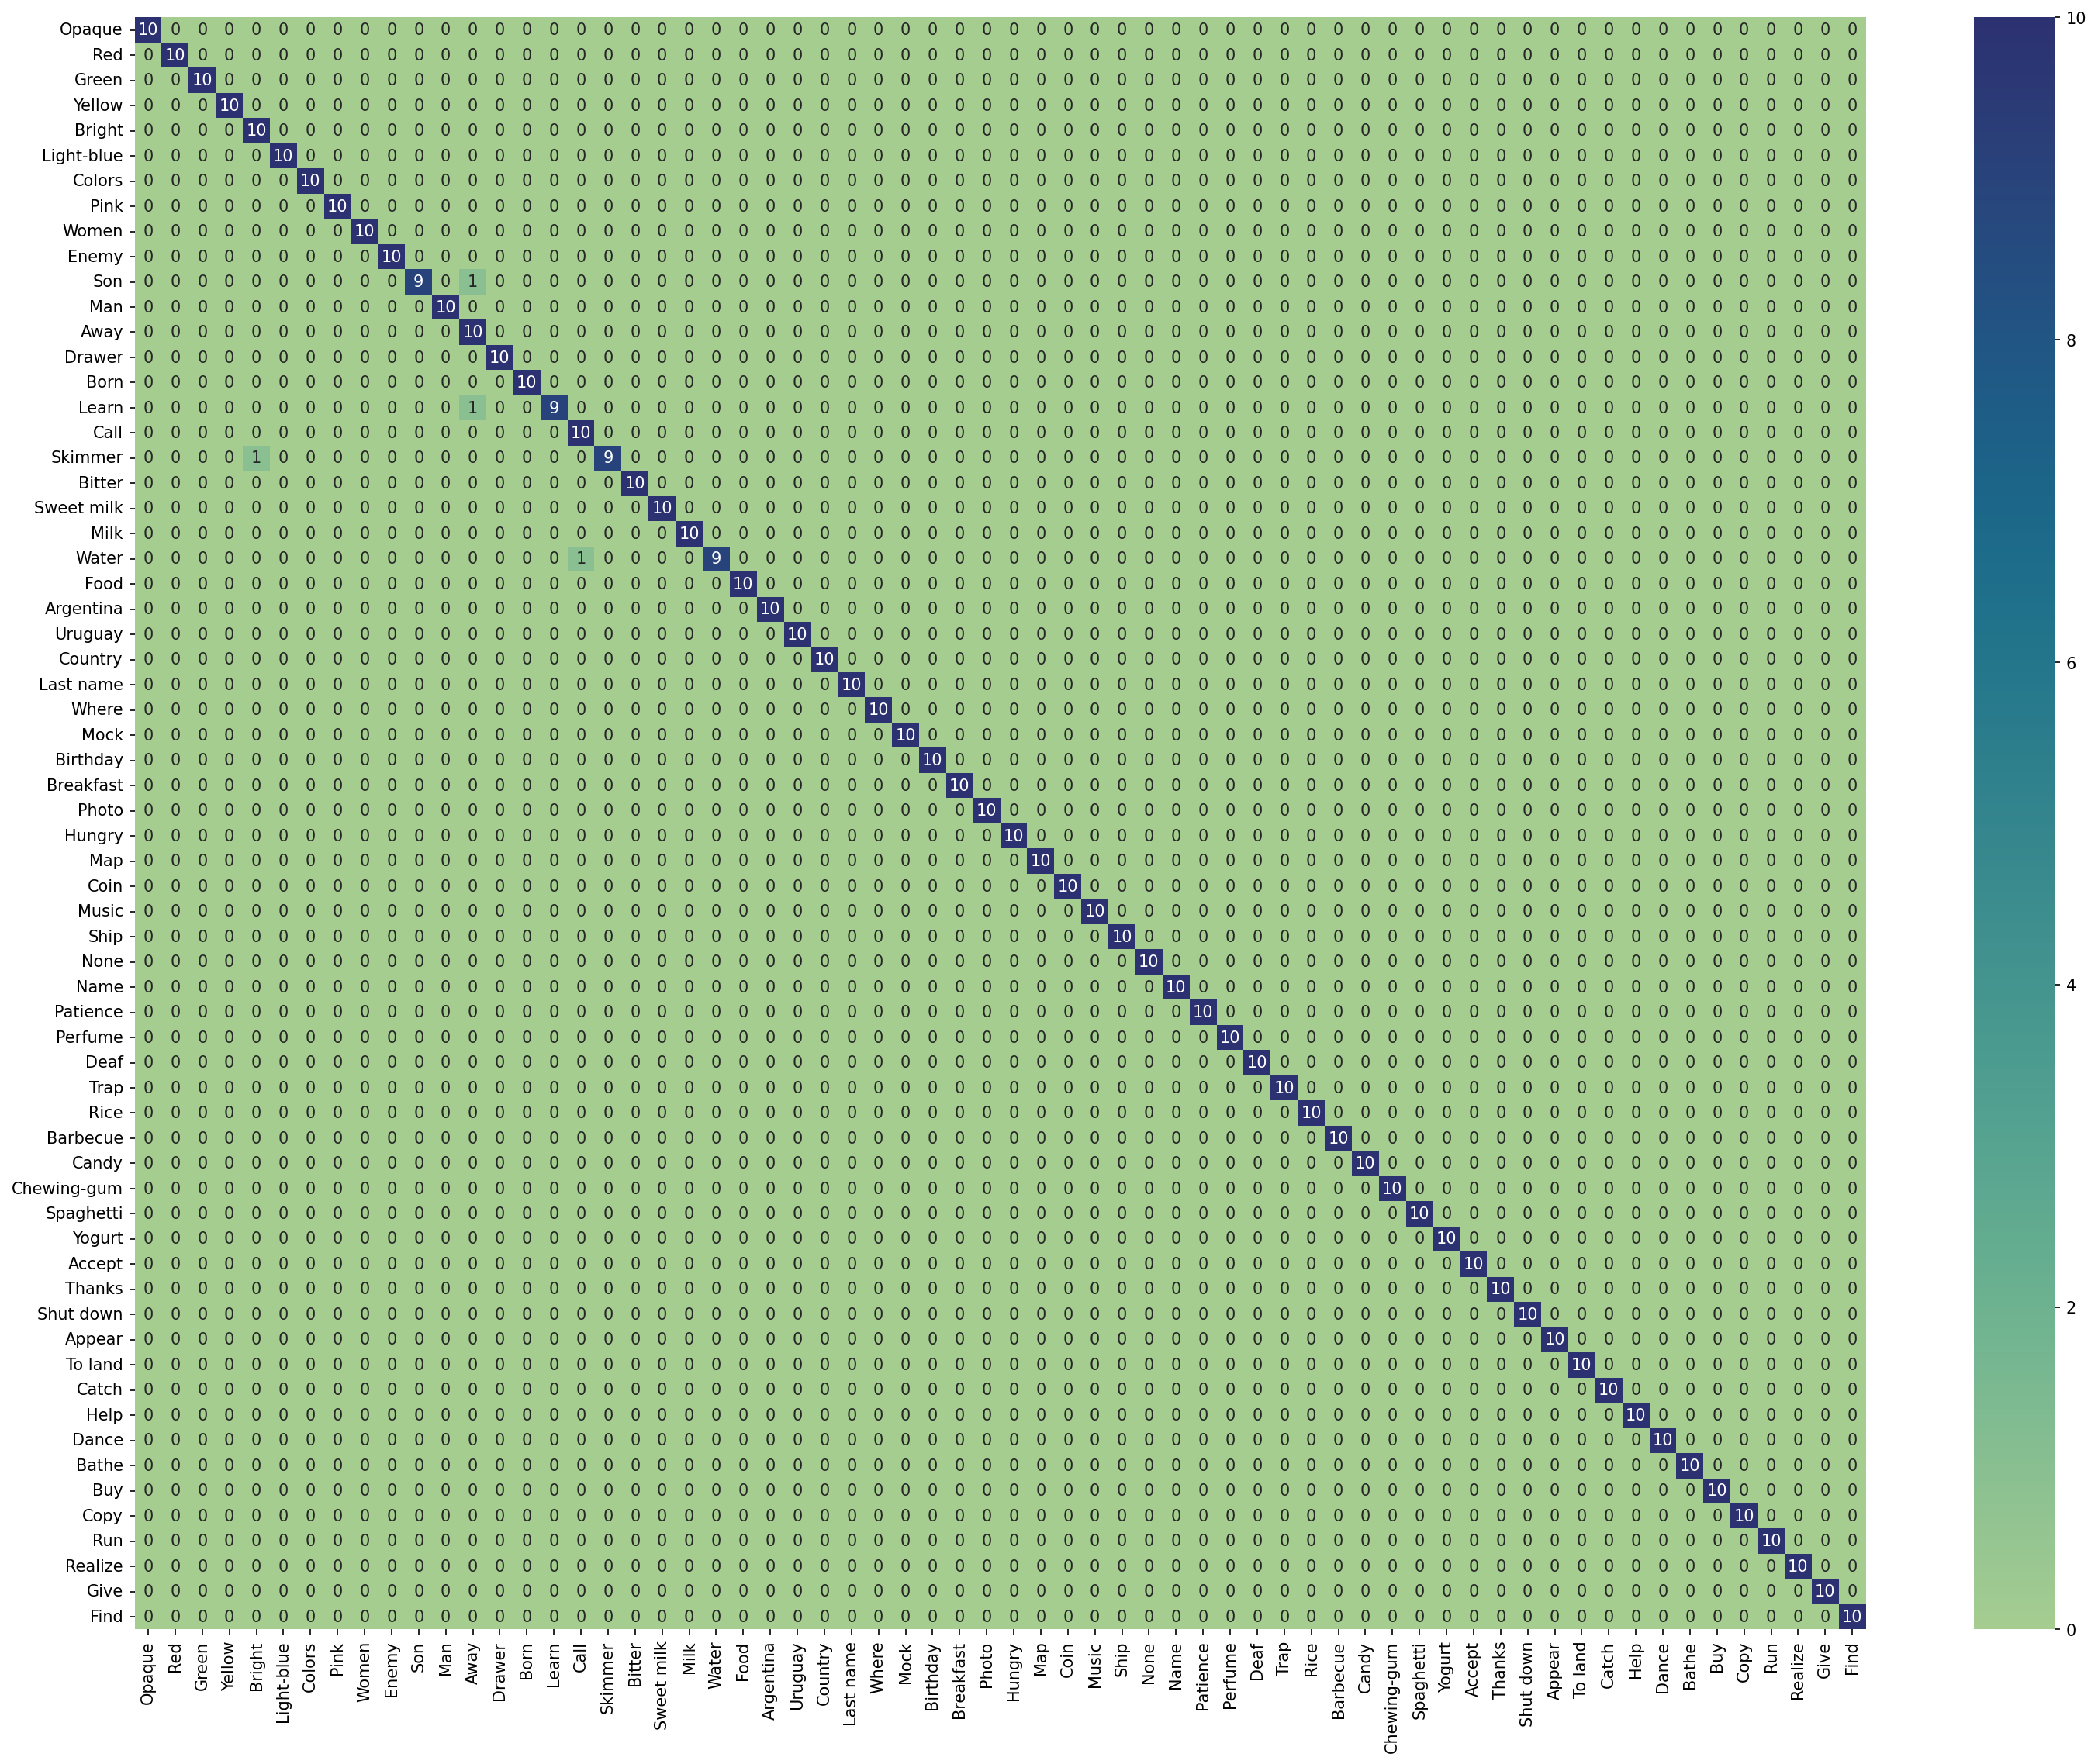

In [74]:
import seaborn as sns

from recognizer.utils.constants import TARGET_TO_WORD

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 18), dpi=150, facecolor="white")

heatmap = sns.heatmap(data=cm, ax=ax, annot=True, cmap="crest")

x_ticks = [int(label.get_text()) for label in heatmap.get_xticklabels()]
y_ticks = [int(label.get_text()) for label in heatmap.get_yticklabels()]

x_new_labels = [TARGET_TO_WORD[ENCODING_TO_TARGET[x]] for x in x_ticks]
y_new_labels = [TARGET_TO_WORD[ENCODING_TO_TARGET[y]] for y in y_ticks]

heatmap.set_xticklabels(x_new_labels)
heatmap.set_yticklabels(y_new_labels)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()
